In [1]:
# 1. U-Net for Segmentation (Oxford-IIIT Pet Dataset)
!pip install -q segmentation-models-pytorch albumentations==1.0.0 pytorch_lightning

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Dataset
class PetDataset(torch.utils.data.Dataset):
    def __init__(self, root, split="trainval"):
        self.dataset = OxfordIIITPet(root=root, split=split, target_types="segmentation", download=True)
        self.transform = T.Compose([
            T.Resize((128, 128)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, mask = self.dataset[idx]
        image = self.transform(image)
        mask = self.transform(mask).long()[0]  # Only one channel
        return image, mask

train_data = PetDataset("data")
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)

# U-Net Model
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def block(in_c, out_c): return nn.Sequential(nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(out_c))
        self.enc1 = block(3, 64)
        self.enc2 = block(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.dec1 = block(128, 64)
        self.final = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        d1 = self.dec1(torch.nn.functional.interpolate(e2, scale_factor=2))
        return self.final(d1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
for epoch in range(2):
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        output = model(imgs)
        loss = criterion(output, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

100%|██████████| 792M/792M [00:36<00:00, 21.8MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.8MB/s]


Epoch 1, Loss: 0.0055
Epoch 2, Loss: 0.0013


In [8]:
# Replace this with the exact path in your Drive where the zip is stored
!cp "/content/drive/MyDrive/AI/DL/archive.zip" crowd_dataset.zip

# Unzip
!unzip -oq crowd_dataset.zip -d crowd_data


In [17]:
import os
import json
import cv2
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CrowdDataset(Dataset):
    def __init__(self, image_root, label_root, transform=None):
        self.image_paths = []
        self.label_paths = []
        self.transform = transform

        # Traverse all folders under images/
        for subdir in os.listdir(image_root):
            img_folder = os.path.join(image_root, subdir)
            label_folder = os.path.join(label_root, subdir)
            if not os.path.isdir(img_folder):
                continue
            for file in os.listdir(img_folder):
                if file.endswith(".jpg"):
                    img_path = os.path.join(img_folder, file)
                    label_path = os.path.join(label_folder, file.replace(".jpg", ".json"))
                    if os.path.exists(label_path):
                        self.image_paths.append(img_path)
                        self.label_paths.append(label_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and resize image
        img = Image.open(self.image_paths[idx]).convert("RGB")
        original_size = img.size  # (width, height)
        img = img.resize((128, 128))
        img_tensor = transforms.ToTensor()(img)

        # Load keypoints from JSON
        with open(self.label_paths[idx], 'r') as f:
            data = json.load(f)

        keypoints = []
        for ann in data.get('annotations', []):
            if 'keypoint' in ann:
                x, y = ann['keypoint']['x'], ann['keypoint']['y']
                keypoints.append((x, y))

        # Generate density map
        density = np.zeros((128, 128), dtype=np.float32)
        w_ratio = 128 / original_size[0]
        h_ratio = 128 / original_size[1]

        for x, y in keypoints:
            x = int(x * w_ratio)
            y = int(y * h_ratio)
            if 0 <= x < 128 and 0 <= y < 128:
                density[y, x] += 1

        # Apply Gaussian blur to simulate crowd density
        density = cv2.GaussianBlur(density, (15, 15), 0)
        density = np.expand_dims(density, axis=0)
        density_tensor = torch.tensor(density, dtype=torch.float32)

        return img_tensor, density_tensor



In [18]:
image_root = "crowd_data/images"
label_root = "crowd_data/labels"

dataset = CrowdDataset(image_root, label_root, transform=transforms.ToTensor())
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"Total training samples: {len(dataset)}")


Total training samples: 20


In [12]:
# Print the contents of the first label file
with open(dataset.label_paths[0], 'r') as f:
    data = json.load(f)
print("First JSON:", data)


First JSON: {'annotations': [{'id': 'dca00b0b-c81b-42f9-90b2-b5850b602cce', 'keypoint': {'x': 1419.82, 'y': 1058.18}, 'name': 'Person1', 'slot_names': ['0']}, {'id': 'edcf7dca-ccbc-4c15-ac65-d27d50537dda', 'keypoint': {'x': 1363.51, 'y': 1060.43}, 'name': 'Person1', 'slot_names': ['0']}, {'id': 'e5309e1d-97da-4df9-8a9e-2d01618073de', 'keypoint': {'x': 1370.66, 'y': 1057.8}, 'name': 'Person1', 'slot_names': ['0']}, {'id': 'a578f461-e2b7-40ad-9cee-9874f25f934a', 'keypoint': {'x': 1340.17, 'y': 967.08}, 'name': 'Person1', 'slot_names': ['0']}, {'id': 'a5c2cd9f-3b08-458b-a79f-26f940783470', 'keypoint': {'x': 1328.12, 'y': 977.24}, 'name': 'Person1', 'slot_names': ['0']}, {'id': 'b05594dd-7f45-4456-be4a-7946e2ed7976', 'keypoint': {'x': 1308.92, 'y': 995.69}, 'name': 'Person1', 'slot_names': ['0']}, {'id': '184572fd-8cba-43e3-b97d-be01e862e20c', 'keypoint': {'x': 1331.89, 'y': 1031.07}, 'name': 'Person1', 'slot_names': ['0']}, {'id': 'd04c8baa-7978-48bd-b9d4-48b5390f8aca', 'keypoint': {'x': 

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        b = self.bottleneck(p2)

        up2 = self.up2(b)
        d2 = self.dec2(torch.cat([up2, e2], dim=1))

        up1 = self.up1(d2)
        d1 = self.dec1(torch.cat([up1, e1], dim=1))

        return self.final(d1)


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_unet = UNet().to(device)
optimizer = torch.optim.Adam(model_unet.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train for 2 epochs (you can increase later)
print("🔧 Training U-Net...")
model_unet.train()
for epoch in range(2):
    epoch_loss = 0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        preds = model_unet(images)
        loss = loss_fn(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"[U-Net] Epoch {epoch+1}: Loss = {epoch_loss / len(train_loader):.4f}")


🔧 Training U-Net...
[U-Net] Epoch 1: Loss = 0.2104
[U-Net] Epoch 2: Loss = 0.0711


In [21]:
import torch.nn as nn

class MCNN(nn.Module):
    def __init__(self):
        super(MCNN, self).__init__()

        # Each branch handles a different scale
        self.branch1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 40, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(24, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(32 + 40 + 48, 1, kernel_size=1)
        )

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat((x1, x2, x3), 1)
        out = self.fuse(x_cat)
        out = nn.functional.interpolate(out, size=(128, 128), mode='bilinear', align_corners=True)
        return out


In [22]:
model_mcnn = MCNN().to(device)
optimizer = torch.optim.Adam(model_mcnn.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print("🔧 Training MCNN...")
model_mcnn.train()
for epoch in range(2):  # You can increase to 10+ later
    total_loss = 0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        preds = model_mcnn(images)
        loss = loss_fn(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"[MCNN] Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")


🔧 Training MCNN...
[MCNN] Epoch 1: Loss = 0.0834
[MCNN] Epoch 2: Loss = 0.0680


In [23]:
torch.save(model_mcnn.state_dict(), "mcnn_crowd_counting.pth")


In [27]:
from torch.utils.data import random_split

dataset_size = len(dataset)
test_size = int(0.2 * dataset_size)  # 20% for test
train_size = dataset_size - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 16, Test samples: 4


In [28]:
import matplotlib.pyplot as plt

def visualize_comparison(images, targets, unet_preds, mcnn_preds, idx=0):
    """
    images: batch tensor, shape [B,3,128,128]
    targets: batch tensor, shape [B,1,128,128]
    unet_preds, mcnn_preds: predicted density maps, same shape as targets
    idx: index in the batch to visualize
    """
    image = images[idx].permute(1, 2, 0).cpu().numpy()
    target = targets[idx][0].cpu().numpy()
    unet_pred = unet_preds[idx][0].cpu().detach().numpy()
    mcnn_pred = mcnn_preds[idx][0].cpu().detach().numpy()

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(image)
    axs[0].set_title("Input Image")
    axs[0].axis('off')

    axs[1].imshow(target, cmap='jet')
    axs[1].set_title("Ground Truth Density")
    axs[1].axis('off')

    axs[2].imshow(unet_pred, cmap='jet')
    axs[2].set_title("U-Net Prediction")
    axs[2].axis('off')

    axs[3].imshow(mcnn_pred, cmap='jet')
    axs[3].set_title("MCNN Prediction")
    axs[3].axis('off')

    plt.show()


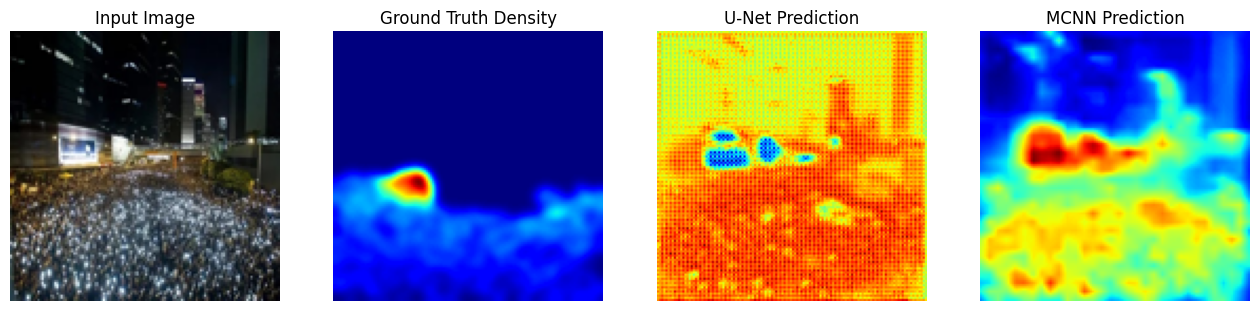

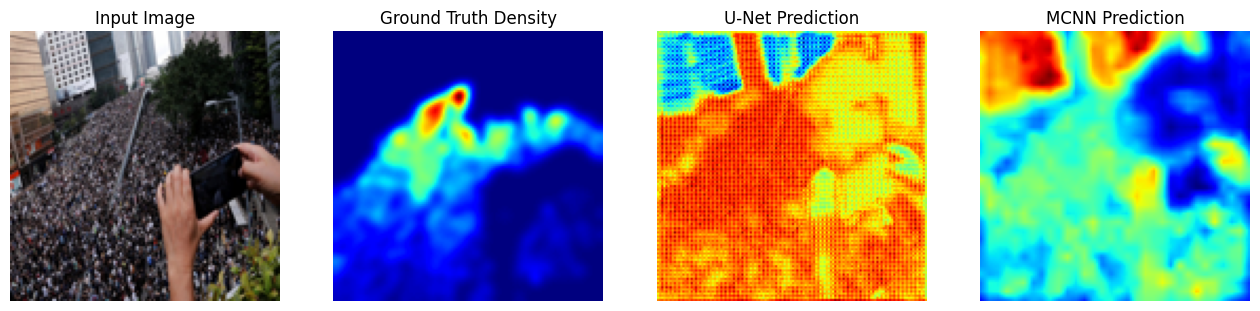

In [29]:
model_unet.eval()
model_mcnn.eval()

with torch.no_grad():
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)

        unet_preds = model_unet(images)
        mcnn_preds = model_mcnn(images)

        # Visualize first 2 samples from batch
        for i in range(min(2, images.size(0))):
            visualize_comparison(images, targets, unet_preds, mcnn_preds, idx=i)
        break  # Just do one batch visualization


In [30]:
import torch
import numpy as np

def evaluate_model(model, dataloader):
    model.eval()
    mae = 0
    mse = 0
    n_samples = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)

            preds = model(images)

            # Sum density map pixels to get counts
            pred_counts = preds.view(preds.size(0), -1).sum(dim=1)
            true_counts = targets.view(targets.size(0), -1).sum(dim=1)

            mae += torch.abs(pred_counts - true_counts).sum().item()
            mse += ((pred_counts - true_counts) ** 2).sum().item()
            n_samples += images.size(0)

    mae /= n_samples
    mse = np.sqrt(mse / n_samples)
    return mae, mse

unet_mae, unet_mse = evaluate_model(model_unet, test_loader)
mcnn_mae, mcnn_mse = evaluate_model(model_mcnn, test_loader)

print(f"U-Net MAE: {unet_mae:.4f}, MSE: {unet_mse:.4f}")
print(f"MCNN MAE: {mcnn_mae:.4f}, MSE: {mcnn_mse:.4f}")


U-Net MAE: 789.8248, MSE: 890.6997
MCNN MAE: 765.8000, MSE: 877.2819


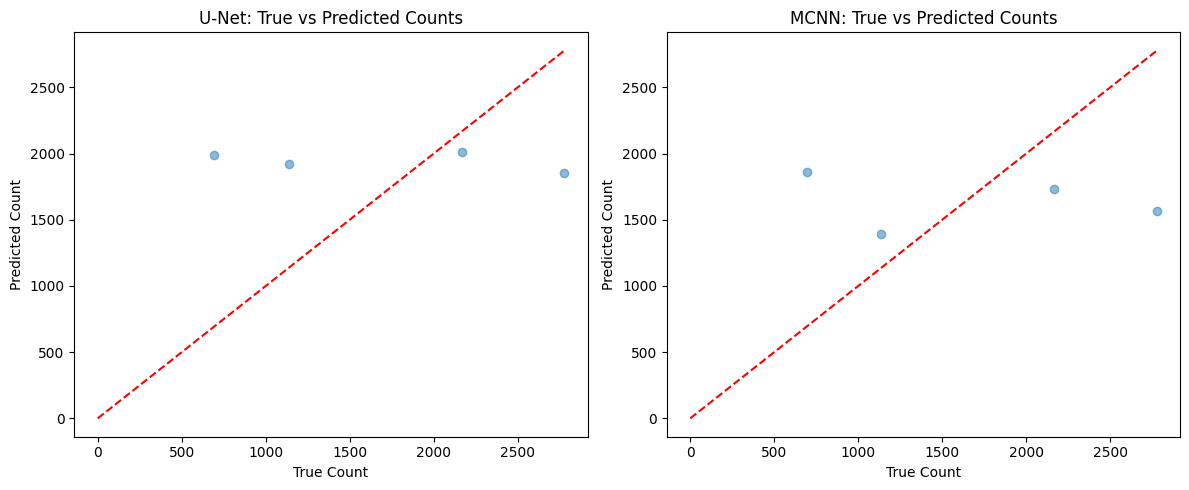

In [31]:
import matplotlib.pyplot as plt

def get_counts(model, dataloader):
    model.eval()
    pred_counts_all = []
    true_counts_all = []
    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)
            preds = model(images)
            pred_counts = preds.view(preds.size(0), -1).sum(dim=1).cpu().numpy()
            true_counts = targets.view(targets.size(0), -1).sum(dim=1).cpu().numpy()
            pred_counts_all.extend(pred_counts)
            true_counts_all.extend(true_counts)
    return np.array(pred_counts_all), np.array(true_counts_all)

unet_pred_counts, unet_true_counts = get_counts(model_unet, test_loader)
mcnn_pred_counts, mcnn_true_counts = get_counts(model_mcnn, test_loader)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(unet_true_counts, unet_pred_counts, alpha=0.5)
plt.plot([0, max(unet_true_counts)], [0, max(unet_true_counts)], 'r--')
plt.title("U-Net: True vs Predicted Counts")
plt.xlabel("True Count")
plt.ylabel("Predicted Count")

plt.subplot(1,2,2)
plt.scatter(mcnn_true_counts, mcnn_pred_counts, alpha=0.5)
plt.plot([0, max(mcnn_true_counts)], [0, max(mcnn_true_counts)], 'r--')
plt.title("MCNN: True vs Predicted Counts")
plt.xlabel("True Count")
plt.ylabel("Predicted Count")

plt.tight_layout()
plt.show()
